# Lecture des données

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('train_cap2018.csv')

# Récupération y_train (80 % des données)

Création de l'ensemble de test

In [3]:
from sklearn.model_selection import train_test_split
test_size = 0.2
random_state = 42

In [4]:
train, test = train_test_split(dataset, test_size=test_size, random_state=random_state, shuffle=True, stratify=dataset.loc[:,'level1'])
print(train.shape)
del test

(21848, 60)


In [5]:
y_train = train.iloc[:, -1]
print(y_train.shape)

(21848,)


In [6]:
y_train = y_train.replace({"A1": 0, "A2" : 1, "B1" : 2, "B2" : 3, "C1" : 4, "C2" : 5})

In [7]:
y_train = np.array(y_train.reset_index().iloc[:,1])

# Récupération de X_train (80 % des données)

In [8]:
import tensorflow as tf
import numpy as np
import scipy.sparse as sparse

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
def load(list_files):
    list_files = np.sort(list_files)
    res = []
    for i in range(list_files.shape[0]):
        if i%100==0 and i > 0:
            print("i=", i)
        res.append(sparse.load_npz(file=list_files[i]))
    return np.array(res)

In [10]:
import glob
list_files = np.array(glob.glob("./texts_matrices/*.npz"))
texts_matrices = load(list_files)
test_dense_load = sparse.csr_matrix.todense(texts_matrices[0])
print(test_dense_load)
print(test_dense_load.shape)

i= 100
i= 200
i= 300
i= 400
i= 500
i= 600
i= 700
i= 800
i= 900
i= 1000
i= 1100
i= 1200
i= 1300
i= 1400
i= 1500
i= 1600
i= 1700
i= 1800
i= 1900
i= 2000
i= 2100
i= 2200
i= 2300
i= 2400
i= 2500
i= 2600
i= 2700
i= 2800
i= 2900
i= 3000
i= 3100
i= 3200
i= 3300
i= 3400
i= 3500
i= 3600
i= 3700
i= 3800
i= 3900
i= 4000
i= 4100
i= 4200
i= 4300
i= 4400
i= 4500
i= 4600
i= 4700
i= 4800
i= 4900
i= 5000
i= 5100
i= 5200
i= 5300
i= 5400
i= 5500
i= 5600
i= 5700
i= 5800
i= 5900
i= 6000
i= 6100
i= 6200
i= 6300
i= 6400
i= 6500
i= 6600
i= 6700
i= 6800
i= 6900
i= 7000
i= 7100
i= 7200
i= 7300
i= 7400
i= 7500
i= 7600
i= 7700
i= 7800
i= 7900
i= 8000
i= 8100
i= 8200
i= 8300
i= 8400
i= 8500
i= 8600
i= 8700
i= 8800
i= 8900
i= 9000
i= 9100
i= 9200
i= 9300
i= 9400
i= 9500
i= 9600
i= 9700
i= 9800
i= 9900
i= 10000
i= 10100
i= 10200
i= 10300
i= 10400
i= 10500
i= 10600
i= 10700
i= 10800
i= 10900
i= 11000
i= 11100
i= 11200
i= 11300
i= 11400
i= 11500
i= 11600
i= 11700
i= 11800
i= 11900
i= 12000
i= 12100
i= 12200
i= 12300
i

In [11]:
filename = "./size_texts.npy"
size_texts = np.load(filename)

In [12]:
print(size_texts.shape)
print(size_texts)

(21848,)
[  41.   14.   80. ...,  129.   33.   71.]


In [13]:
print(y_train.shape)

(21848,)


# Séparation de X_train, y_train en deux ensembles: un ensemble d'entrainement et un ensemble de validation.

In [14]:
training_size = 0.7

X_train = texts_matrices[0:int(texts_matrices.shape[0]*training_size)]
y_train_full = y_train
y_train = y_train_full[0:int(texts_matrices.shape[0]*training_size)]
size_texts_train = size_texts[0:int(texts_matrices.shape[0]*training_size)]

X_val = texts_matrices[int(texts_matrices.shape[0]*training_size):]
y_val = y_train_full[int(texts_matrices.shape[0]*training_size):]
size_texts_val = size_texts[int(texts_matrices.shape[0]*training_size):]

Nombre d'éléments par classe dans l'ensemble d'entrainement:

In [15]:
nb_texts_per_classe = np.zeros(6)
for i in range(y_train.shape[0]):
    nb_texts_per_classe[y_train[i]] = nb_texts_per_classe[y_train[i]] + 1
print(nb_texts_per_classe)

[ 6379.  4332.  2968.  1319.   269.    26.]


Nombre d'éléments par classe dans l'ensemble de validation:

In [16]:
print(y_val)
nb_texts_per_classe = np.zeros(6)
for i in range(y_val.shape[0]):
    nb_texts_per_classe[y_val[i]] = nb_texts_per_classe[y_val[i]] + 1
print(nb_texts_per_classe)

[0 2 2 ..., 3 0 1]
[ 2710.  1818.  1338.   551.   124.    14.]


# RNN

# Fonction de création et d'entrainement d'un RNN:

On commence par définir une fonction pour récupérer les données par lot:

In [17]:
def get_next_batch(texts_matrices, iteration, batch_size):
    size_text = texts_matrices[0].shape[0]
    size_word = texts_matrices[0].shape[1]
    #print("(batch_size, size_text, size_word)=", batch_size, size_text, size_word)
    X_batch = np.zeros((batch_size, size_text, size_word)) 
    temp1 = texts_matrices[iteration*batch_size:(iteration+1)*batch_size]
    for i in range(temp1.shape[0]):
        X_batch[i] = np.array(sparse.csr_matrix.todense(temp1[i]))
    return X_batch
#test
temp = get_next_batch(X_train, 0, 3)
temp.shape

(3, 418, 300)

La cellule ci-dessous implémente la fonction d'erreur de la compétition. Malheureusement argmax n'est pas différentiable donc la fonction n'est pas utilisable comme fonction de coût.

In [18]:
costs_tf = tf.constant([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,12,4,0,8],[44,38,32,19,13,0]])

def cost_tf(inference, y_true):
    y_pred = tf.argmax(inference, axis=1) #pas différentiable...
    confusion = tf.confusion_matrix(y_true, y_pred, num_classes=6)
    res1 = tf.multiply(costs, confusion)
    res2 = tf.reduce_sum(res1)
    res3 = tf.divide(res2, tf.shape(y_true)[0])
    return res3

In [39]:
import tensorflow as tf

def create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=500, activation=tf.nn.relu, 
                               dropout_in=0, dropout_out=0, class_weights=[1, 1, 1, 1, 1, 1], learning_rate=0.001, n_epochs=100, batch_size=200, max_checks_without_progress=3):
    
    tf.reset_default_graph()
    
    X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs], name="X")
    seq_length = tf.placeholder(tf.int32, [None]) #vecteur avec les nombres de mots dans les textes
    y = tf.placeholder(tf.int64, shape=[None], name="y")

    dropout_in_placeholder = tf.placeholder_with_default(tf.constant(0.0, dtype=tf.float32), ())
    dropout_out_placeholder = tf.placeholder_with_default(tf.constant(0.0, dtype=tf.float32), ())

    basic_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=activation)
    basic_cell = tf.contrib.rnn.DropoutWrapper(basic_cell, input_keep_prob=1-dropout_in_placeholder, output_keep_prob=1-dropout_out_placeholder)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

    logits = tf.layers.dense(inputs=states, units=n_outputs, name="logits")
    inference = tf.nn.softmax(logits, name="inference")

    with tf.name_scope("loss"):
        #loss = cost(inference, y)

        class_weights_tf = tf.constant(class_weights)
        weights = tf.gather(class_weights_tf, y)
        xentropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits, weights=weights)
        #xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y) #ancienne version (sans poids)
        loss = tf.reduce_mean(xentropy, name="loss")

    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    summary_writer = tf.summary.FileWriter("./summary", tf.get_default_graph())

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    n_batches_per_epoch = X_train.shape[0] // batch_size
    print("Nombre de batchs par epoch =", n_batches_per_epoch)
    
    best_loss = np.infty
    checks_without_progress = 0
    
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for iteration in range(n_batches_per_epoch):
                if (iteration+1)%10==0:
                    print("Batch n°", iteration+1)
                X_batch = get_next_batch(X_train, iteration, batch_size)
                y_batch = y_train[iteration*batch_size:(iteration+1)*batch_size]

                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, seq_length: size_texts_train[iteration*batch_size:(iteration+1)*batch_size], dropout_in_placeholder: dropout_in, dropout_out_placeholder: dropout_out})

            #fonction de coût sur les 5000 premiers textes d'entrainement (pour que ça tienne dans la mémoire vive)
            nb_training_examples = 5000
            if X_train.shape[0] < nb_training_examples:
                nb_training_examples = X_train.shape[0]
            loss_train = loss.eval(feed_dict={X: get_next_batch(X_train[0:nb_training_examples], 0, nb_training_examples), y: y_train[0:nb_training_examples], seq_length: size_texts_train[0:nb_training_examples]})
            loss_val = loss.eval(feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), y: y_val, seq_length: size_texts_val[0:X_val.shape[0]]})
            print(epoch, "Loss training:", loss_train)
            print(epoch, "Loss validation:", loss_val)

            if loss_val < best_loss:
                save_path = saver.save(sess, "./natural_language_classifier.ckpt")
                best_loss = loss_val
                checks_without_progress = 0
            else:
                checks_without_progress += 1
                if checks_without_progress >= MAX_CHECKS_WITHOUT_PROGRESS:
                    print("Early stopping!")
                    break
    return inference, X, seq_length

# Entrainement avec l'ensemble des données d'entrainement

In [20]:
n_steps = X_train[0].shape[0] #taille des textes (rendue fixe)
n_inputs = X_train[0].shape[1] #taille des vecteurs représentant chaque mot
print("Nombre de mots des textes (fixe) =", n_steps)
print("Taille vecteur d'un mot =", n_inputs)
n_neurons = 500
activation = tf.nn.relu
n_outputs = 6
class_weights = [1, 1, 1, 1, 1, 1] #poids de la fonction de coût
learning_rate = 0.001

n_epochs = 100
batch_size = 200

MAX_CHECKS_WITHOUT_PROGRESS = 3

Nombre de mots des textes (fixe) = 418
Taille vecteur d'un mot = 300


In [21]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation, class_weights=class_weights,
                           learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 0.610982
0 Loss validation: 0.630371
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 0.452072
1 Loss validation: 0.486627
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 0.328646
2 Loss validation: 0.375238
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 0.290011
3 Loss validation: 0.355088
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 0.182437
4 Loss validation: 0.276897
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 0.187664
5 Loss validation: 0.314224
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 0.119885
6 Loss validation: 0.266472
Ba

# Mesure de l'erreur

In [22]:
costs = np.array([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,12,4,0,8],[44,38,32,19,13,0]])
names = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

In [23]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
from sklearn.metrics import confusion_matrix
print_confusion = True
def cost(y_pred, y_true, normalize=True):
    confusion = confusion_matrix(y_true, y_pred)
    res = (1/y_true.shape[0]) * np.sum(np.multiply(costs, confusion))
    
    if print_confusion:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, normalize=normalize, title='Normalized confusion matrix')

        plt.show()
    return res

Matrice de confusion + erreur pour l'ensemble de validation

INFO:tensorflow:Restoring parameters from ./natural_language_classifier.ckpt
Normalized confusion matrix
[[  9.52e-01   3.47e-02   1.03e-02   2.95e-03   3.69e-04   0.00e+00]
 [  2.59e-02   8.98e-01   6.33e-02   1.21e-02   1.10e-03   0.00e+00]
 [  1.05e-02   2.09e-02   9.27e-01   3.89e-02   2.99e-03   0.00e+00]
 [  3.63e-03   2.18e-02   9.98e-02   8.58e-01   1.63e-02   0.00e+00]
 [  1.61e-02   3.23e-02   1.05e-01   3.63e-01   4.84e-01   0.00e+00]
 [  7.14e-02   7.14e-02   0.00e+00   6.43e-01   2.14e-01   0.00e+00]]


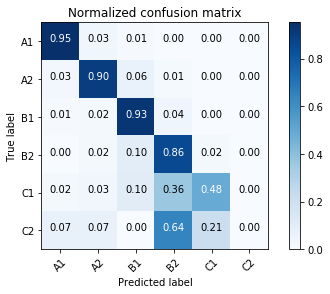

0.280854309687


In [25]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    res = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))

# Entrainement d'un deuxième réseau mais avec des poids pour la fonction de coût

Les poids sont calculés par rapport à la répartition des effectifs des classes dans l'ensemble des données de la compétition.

In [26]:
class_weights = [1, 1.48, 2.11, 4.86, 23.14, 227.22] #poids de la fonction de coût

In [27]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation, class_weights=class_weights,
                           learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 4.18642
0 Loss validation: 4.23027
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 2.78376
1 Loss validation: 2.92574
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 2.21989
2 Loss validation: 2.60208
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 1.72744
3 Loss validation: 2.33075
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 1.3587
4 Loss validation: 2.37909
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 1.1485
5 Loss validation: 2.5439
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 0.799327
6 Loss validation: 2.53891
Early stopping!


INFO:tensorflow:Restoring parameters from ./natural_language_classifier.ckpt
Normalized confusion matrix
[[ 0.9   0.08  0.01  0.01  0.    0.  ]
 [ 0.09  0.82  0.08  0.01  0.    0.  ]
 [ 0.02  0.14  0.69  0.11  0.01  0.03]
 [ 0.01  0.03  0.13  0.56  0.1   0.18]
 [ 0.    0.02  0.09  0.19  0.35  0.34]
 [ 0.07  0.    0.    0.21  0.21  0.5 ]]


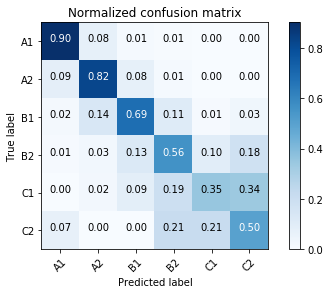

0.639511823036


In [28]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    res = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))

In [29]:
class_weights = [1, 1.48, 2.11, 4.86, 23.14, 50] #poids de la fonction de coût

In [30]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation, class_weights=class_weights,
                           learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 2.24097
0 Loss validation: 2.20897
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 1.78795
1 Loss validation: 1.87964
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 1.47253
2 Loss validation: 1.65873
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 1.2893
3 Loss validation: 1.53292
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 0.985905
4 Loss validation: 1.36603
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 0.742715
5 Loss validation: 1.30801
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 1.16881
6 Loss validation: 1.77742
Batch n° 10
Bat

INFO:tensorflow:Restoring parameters from ./natural_language_classifier.ckpt
Normalized confusion matrix
[[  9.39e-01   4.39e-02   9.96e-03   3.32e-03   3.32e-03   0.00e+00]
 [  5.56e-02   8.92e-01   4.07e-02   9.35e-03   2.20e-03   5.50e-04]
 [  1.27e-02   6.58e-02   8.10e-01   8.45e-02   2.32e-02   3.74e-03]
 [  3.63e-03   2.00e-02   8.35e-02   8.33e-01   5.81e-02   1.81e-03]
 [  0.00e+00   4.03e-02   4.84e-02   9.68e-02   8.06e-01   8.06e-03]
 [  7.14e-02   0.00e+00   7.14e-02   2.14e-01   4.29e-01   2.14e-01]]


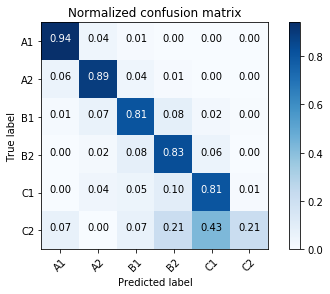

0.318077803204


In [31]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    res = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))

# Dropout

In [32]:
n_steps = X_train[0].shape[0] #taille des textes (rendue fixe)
n_inputs = X_train[0].shape[1] #taille des vecteurs représentant chaque mot
print("Nombre de mots des textes (fixe) =", n_steps)
print("Taille vecteur d'un mot =", n_inputs)
n_neurons = 500
activation = tf.nn.relu
dropout_in = 0.5
dropout_out = 0.5

n_outputs = 6
class_weights = [1, 1, 1, 1, 1, 1] #poids de la fonction de coût
learning_rate = 0.001

n_epochs = 100
batch_size = 200

MAX_CHECKS_WITHOUT_PROGRESS = 3

Nombre de mots des textes (fixe) = 418
Taille vecteur d'un mot = 300


In [33]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation, 
                                                      dropout_in=dropout_in, dropout_out=dropout_out, class_weights=class_weights, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)


Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 0.718625
0 Loss validation: 0.73368
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 0.596148
1 Loss validation: 0.619066
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 0.471474
2 Loss validation: 0.506758
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 0.324939
3 Loss validation: 0.369735
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 0.30705
4 Loss validation: 0.35888
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 0.237563
5 Loss validation: 0.301265
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 0.199817
6 Loss validation: 0.271088
Batch

INFO:tensorflow:Restoring parameters from ./natural_language_classifier.ckpt
Normalized confusion matrix
[[  9.67e-01   2.10e-02   9.59e-03   1.48e-03   1.11e-03   0.00e+00]
 [  2.92e-02   9.28e-01   3.52e-02   7.15e-03   5.50e-04   0.00e+00]
 [  1.64e-02   2.09e-02   9.25e-01   3.14e-02   5.98e-03   0.00e+00]
 [  1.81e-03   1.27e-02   9.80e-02   8.38e-01   4.90e-02   0.00e+00]
 [  2.42e-02   5.65e-02   6.45e-02   1.13e-01   7.42e-01   0.00e+00]
 [  1.43e-01   0.00e+00   0.00e+00   2.14e-01   6.43e-01   0.00e+00]]


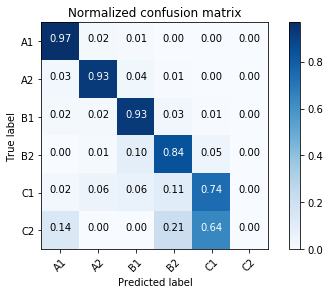

0.238596491228


In [34]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    res = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))

# Dropout + plus de neurones

In [40]:
n_steps = X_train[0].shape[0] #taille des textes (rendue fixe)
n_inputs = X_train[0].shape[1] #taille des vecteurs représentant chaque mot
print("Nombre de mots des textes (fixe) =", n_steps)
print("Taille vecteur d'un mot =", n_inputs)
n_neurons = 1000
activation = tf.nn.relu
dropout_in = 0.5
dropout_out = 0.5

n_outputs = 6
class_weights = [1, 1, 1, 1, 1, 1] #poids de la fonction de coût
learning_rate = 0.001

n_epochs = 100
batch_size = 200

MAX_CHECKS_WITHOUT_PROGRESS = 3

Nombre de mots des textes (fixe) = 418
Taille vecteur d'un mot = 300


In [ ]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation, 
                                                      dropout_in=dropout_in, dropout_out=dropout_out, class_weights=class_weights, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)


Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 1.03934
0 Loss validation: 1.05157
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 0.567374
1 Loss validation: 0.590449
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 0.476503
2 Loss validation: 0.510276
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 0.348922
3 Loss validation: 0.387917
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 0.279219
4 Loss validation: 0.334058
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 0.246904
5 Loss validation: 0.312119
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 0.204287
6 Loss validation: 0.28699
Batch

In [ ]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    res = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))

# Problème régression

In [ ]:
print(y_train)
print(y_train.shape)

In [ ]:
n_steps = X_train[0].shape[0] #taille des textes (rendue fixe)
n_inputs = X_train[0].shape[1] #taille des vecteurs représentant chaque mot
print("Nombre de mots des textes (fixe) =", n_steps)
print("Taille vecteur d'un mot =", n_inputs)
n_neurons = 500
activation = tf.nn.relu
n_outputs = 6
learning_rate = 0.001

n_epochs = 100
batch_size = 200

MAX_CHECKS_WITHOUT_PROGRESS = 3

In [ ]:
import tensorflow as tf

def create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=500, activation=tf.nn.relu,
                               learning_rate=0.001, n_epochs=100, batch_size=200, max_checks_without_progress=3):
    
    tf.reset_default_graph()
    
    X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs], name="X")
    seq_length = tf.placeholder(tf.int32, [None]) #vecteur avec les nombres de mots dans les textes
    y = tf.placeholder(tf.int64, shape=[None], name="y")

    basic_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=activation)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

    mark_temp = tf.layers.dense(inputs=states, units=1, name="mark")
    mark = tf.reshape(mark_temp, [-1])
    inference = tf.round(mark, name="inference")

    with tf.name_scope("loss"):
        loss = tf.losses.mean_squared_error(y, mark)
        
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

    summary_writer = tf.summary.FileWriter("./summary", tf.get_default_graph())

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    n_batches_per_epoch = X_train.shape[0] // batch_size
    print("Nombre de batchs par epoch =", n_batches_per_epoch)
    
    best_loss = np.infty
    checks_without_progress = 0
    
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for iteration in range(n_batches_per_epoch):
                if (iteration+1)%10==0:
                    print("Batch n°", iteration+1)
                X_batch = get_next_batch(X_train, iteration, batch_size)
                y_batch = y_train[iteration*batch_size:(iteration+1)*batch_size]

                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, seq_length: size_texts_train[iteration*batch_size:(iteration+1)*batch_size]})

            #fonction de coût sur les 5000 premiers textes d'entrainement (pour que ça tienne dans la mémoire vive)
            nb_training_examples = 5000
            if X_train.shape[0] < nb_training_examples:
                nb_training_examples = X_train.shape[0]
            loss_train = loss.eval(feed_dict={X: get_next_batch(X_train[0:nb_training_examples], 0, nb_training_examples), y: y_train[0:nb_training_examples], seq_length: size_texts_train[0:nb_training_examples]})
            loss_val = loss.eval(feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), y: y_val, seq_length: size_texts_val[0:X_val.shape[0]]})
            print(epoch, "Loss training:", loss_train)
            print(epoch, "Loss validation:", loss_val)

            if loss_val < best_loss:
                save_path = saver.save(sess, "./natural_language_classifier.ckpt")
                best_loss = loss_val
                checks_without_progress = 0
            else:
                checks_without_progress += 1
                if checks_without_progress >= MAX_CHECKS_WITHOUT_PROGRESS:
                    print("Early stopping!")
                    break
    return inference, X, seq_length

In [ ]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation,
                           learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

In [ ]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    y_pred = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    #y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))